<a href="https://colab.research.google.com/github/euna-jeong20/hands-on-machine-learning/blob/main/05_support_vector_machines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**5장 – 서포트 벡터 머신**

_이 노트북은 5장에 있는 모든 샘플 코드와 연습문제 해답을 가지고 있습니다._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/handson-ml2/blob/master/05_support_vector_machines.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

# 설정

먼저 몇 개의 모듈을 임포트합니다. 맷플롯립 그래프를 인라인으로 출력하도록 만들고 그림을 저장하는 함수를 준비합니다. 또한 파이썬 버전이 3.5 이상인지 확인합니다(파이썬 2.x에서도 동작하지만 곧 지원이 중단되므로 파이썬 3을 사용하는 것이 좋습니다). 사이킷런 버전이 0.20 이상인지도 확인합니다.

In [ ]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "svm"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 라지 마진 분류

다음 몇 개의 코드 셀은 5장 앞부분의 그래프를 만듭니다. 실제 코드 예제는 그 이후에 나옵니다:

SVM에는 SVC와 linearSVC 클래스가 있다

SVC

라이브러리는 libsvm
OvO전략
비선형/선형 모델 둘 다 
손실함수는 힌지손실 사용

LinearSVC

라이브러리는 liblinear
OVR전략
선형모델만
손실함수는 squared_hinge(제곱 힌지 손실)


In [ ]:
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비 (2차원으로 하려고 특성 2개만)
y = iris["target"]

setos_or_versicoloar = (y == 0) | (y == 1)      #세토사종또는 버지컬러이면 True
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

# SVM 분류 모델
svm_clf = SVC(kernel="linear", C=float("inf"))      
#선형, LinearSVC와 비슷 
#C값이 커지면 규제가 약해진다 C=float("inf") -> 규제가 거의 없다 (참고로 앞에 규제있는 선형 회귀모델에서는 알파가 커질수록 규제가 강해진다 )
svm_clf.fit(X, y)
svm_clf.predict([[4, 0.2]])

NameError: ignored

결정경계를 이루는 hyperplane 식 :$W^{T}X + b = 0$

클래스 A의 서포트 벡터를 지나는 hyperplane 식 :$W^{T}X + b = 1$

클래스 B의 서포트 벡터를 지나는 hyperplane 식 :$W^{T}X + b = -1$

NameError: ignored

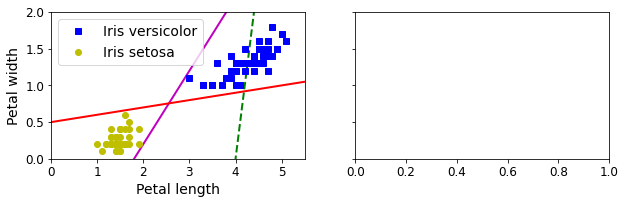

In [ ]:
# 나쁜 모델 왼쪽 그래프를 그리는데 이용 (설명을 위해 왼쪽 그래프의 결정 경계를 임의로 그음)
x0 = np.linspace(0, 5.5, 200)
pred_1 = 5*x0 - 20
pred_2 = x0 - 1.8
pred_3 = 0.1 * x0 + 0.5

def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]        #svm_clf.coef_ 은 2차원 배열이지만 [0]을 해서 1차원 배열로 가져온다
    b = svm_clf.intercept_[0]

    #결정경계 그리기(오른쪽 그래프의 실선)
    #결정 경계에서 w0*x0 + w1*x1 + b = 0 이므로
    #=> x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)       # xmin~xmax사이에 균등한 200개의 숫자 배열 
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]        # 결정경계식에 x0(꽃잎길이)을 대입해서 x1(꽃잎 너비)를 얻음

    margin = 1/w[1]     #폭
    gutter_up = decision_boundary + margin  #-w[0]/w[1] * x0  + 1/w[1]*(1-b)
    gutter_down = decision_boundary - margin    #-w[0]/w[1] * x0  - 1/w[1]*(1+b)

    svs = svm_clf.support_vectors_
    #support_verctors는 결정경계와 가장 가까운 훈련셋의 데이터 좌표(벡터)
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')  #각 클래스의 서포트벡터 표시
    plt.plot(x0, decision_boundary, "k-", linewidth=2)      #결정경계
    plt.plot(x0, gutter_up, "k--", linewidth=2)             #버지컬러종의 서포트 벡터를 지나는 직선의 방정식
    plt.plot(x0, gutter_down, "k--", linewidth=2)           #세토사종의 서포트 벡터를 지나는 직선의 방정식

fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

plt.sca(axes[0])    #왼쪽 그래프
plt.plot(x0, pred_1, "g--", linewidth=2)
plt.plot(x0, pred_2, "m-", linewidth=2)
plt.plot(x0, pred_3, "r-", linewidth=2)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.sca(axes[1])    #오른쪽 그래프
plot_svc_decision_boundary(svm_clf, 0, 5.5)

plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")        #버지컬러 종의 꽃잎길이와 꽃잎너비의 산점도
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")        #세토사 종의 꽃잎길이와 꽃잎너비의 산점도
plt.xlabel("Petal length", fontsize=14)
plt.axis([0, 5.5, 0, 2])

save_fig("large_margin_classification_plot")
plt.show()

https://skyil.tistory.com/150

# 특성의 스케일에 민감함

In [ ]:
#스케일 안한거
Xs = np.array([[1, 50], [5, 20], [3, 80], [5, 60]]).astype(np.float64)      #임의의 데이터 (총 점4개)
ys = np.array([0, 0, 1, 1])
svm_clf = SVC(kernel="linear", C=100)
svm_clf.fit(Xs, ys)

plt.figure(figsize=(9,2.7))
plt.subplot(121)
plt.plot(Xs[:, 0][ys==1], Xs[:, 1][ys==1], "bo")
plt.plot(Xs[:, 0][ys==0], Xs[:, 1][ys==0], "ms")

plot_svc_decision_boundary(svm_clf, 0, 6)       #모델, x축의 범위

plt.xlabel("$x_0$", fontsize=20)
plt.ylabel("$x_1$    ", fontsize=20, rotation=0)
plt.title("Unscaled", fontsize=16)
plt.axis([0, 6, 0, 90])

#스케일링 한거
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xs)
svm_clf.fit(X_scaled, ys)

plt.subplot(122)
plt.plot(X_scaled[:, 0][ys==1], X_scaled[:, 1][ys==1], "bo")
plt.plot(X_scaled[:, 0][ys==0], X_scaled[:, 1][ys==0], "ms")

plot_svc_decision_boundary(svm_clf, -2, 2)

plt.xlabel("$x_0$", fontsize=20)
plt.ylabel("$x'_1$  ", fontsize=20, rotation=0)
plt.title("Scaled", fontsize=16)
plt.axis([-2, 2, -2, 2])

save_fig("sensitivity_to_feature_scales_plot")


# 이상치에 민감함

In [ ]:
X_outliers = np.array([[3.4, 1.3], [3.2, 0.8]])     #각각 왼쪽 오른쪽 그래프에 들어갈 임의의 이상치
y_outliers = np.array([0, 0])

Xo1 = np.concatenate([X, X_outliers[:1]], axis=0)   #첫번째 이상치를 넣음
yo1 = np.concatenate([y, y_outliers[:1]], axis=0)
Xo2 = np.concatenate([X, X_outliers[1:]], axis=0)   #두번째 이상치를 넣음
yo2 = np.concatenate([y, y_outliers[1:]], axis=0)

svm_clf2 = SVC(kernel="linear", C=10**9)
svm_clf2.fit(Xo2, yo2)
fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

#svm_clf1 = SVC(kernel='linear', C=10**9)
svm_clf1 = SVC(kernel='linear', C=np.inf, max_iter=100)     #규제 거의 없고 반복횟수제한
svm_clf1.fit(Xo1, yo1)


plt.sca(axes[0])        #왼쪽 그래프
plt.plot(Xo1[:, 0][yo1==1], Xo1[:, 1][yo1==1], "bs")
plt.plot(Xo1[:, 0][yo1==0], Xo1[:, 1][yo1==0], "yo")
plot_svc_decision_boundary(svm_clf1, 0, 5.5)
plt.text(0.3, 1.0, "Impossible!", fontsize=24, color="red")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[0][0], X_outliers[0][1]),
             xytext=(2.5, 1.7),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

plt.sca(axes[1])        #오른쪽 그래프
plt.plot(Xo2[:, 0][yo2==1], Xo2[:, 1][yo2==1], "bs")
plt.plot(Xo2[:, 0][yo2==0], Xo2[:, 1][yo2==0], "yo")

plot_svc_decision_boundary(svm_clf2, 0, 5.5)        #결정경계구해서 그리기

plt.xlabel("Petal length", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[1][0], X_outliers[1][1]),
             xytext=(3.2, 0.08),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

save_fig("sensitivity_to_outliers_plot")
plt.show()

모든 샘플이 도로(점선 바깥쪽)에서 올바르게 분류되었다면 이를 하드 마진 분류라고한다.

하드 마진 분류의 문제점
1. 데이터가 선형적으로 구분될 수 있어야 제대로 작동
2. 이상치에 민감하다

위에 그래프를 보면

왼쪽 그래프에서는 하드 마진을 찾을 수 없다.


오른쪽 그래프에서는 이상치를 서포트벡터로 인식해 아까와 결정경계가 다르고 일반화가 잘 되지않을 것이다.

# 라지 마진 vs 마진 오류

다음이 5장의 첫 번째 코드 예제입니다:

In [ ]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = (iris["target"] == 2).astype(np.float64)  # 버지니카종인 경우에만 1, 아니면 0

svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(C=1, loss="hinge", random_state=42)),      #위에 SVC와 비숫하게 하려고 손실함수를 힌지로
    ])

svm_clf.fit(X, y)

In [ ]:
svm_clf.predict([[5.5, 1.7]])

여러가지 규제 설정을 비교하는 그래프를 만들겠습니다:

In [ ]:
scaler = StandardScaler()
svm_clf1 = LinearSVC(C=1, loss="hinge", random_state=42)        #규제를 함
svm_clf2 = LinearSVC(C=100, loss="hinge", random_state=42)      #규제를 거의 안함

scaled_svm_clf1 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf1),
    ])

scaled_svm_clf2 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf2),
    ])

scaled_svm_clf1.fit(X, y)
scaled_svm_clf2.fit(X, y)

In [ ]:
# 원본에다가 그래프 그리려고
# 스케일되지 않은 파라미터로 변경
#z = (x - mean) / std
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])        #위에 식에서 x가 0인경우에 b가 구해지니까
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])

w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_

#위에서 구한 절편과 가중치를 원래 모델 파라미터에 대입
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

# 서포트 벡터 찾기 (LInearSVC의 liblinear 라이브러리에서는 서포트 벡터제공하지않는다)
# 힌지 손실 : max(0, 1-t*y) where t=1(양성) or -1(음성), y=결정함수값
# if t*y > 1 , 힌지손실값은 0
# if t*y < 1 , 힌지손실값은 1-t*y
# t가 양성(1), y > 1인 경우와 t가 음성(-1), y < -1 인 경우 힌지손실값이 0 

t = y * 2 - 1       #지금 y = 0 or 1 식에 대입하면--> t = -1 or 1
                    #SVC클래스와 LinearSVC클래스는 y값이 0과 1이여도 -1과 1로 바꿔서 훈련한다(로지스틱 회귀도)

support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()   #손실이 있는 (샘플이 도로에 있는 경우) 샘플의 인덱스를 얻음(계산 결과가 참이면 True, 아니면 False)
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()

svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

plt.sca(axes[0])        #왼쪽 그래프
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris versicolor")

plot_svc_decision_boundary(svm_clf1, 4, 5.9)

plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("$C = {}$".format(svm_clf1.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])

plt.sca(axes[1])        #오른쪽 그래프
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")

plot_svc_decision_boundary(svm_clf2, 4, 5.99)

plt.xlabel("Petal length", fontsize=14)
plt.title("$C = {}$".format(svm_clf2.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])

save_fig("regularization_plot")

C가 작으면 규제가 강해진다 -> 모델이 단순 -> 폭(마진)이 커진다 ->마진오류가 많이 생긴다

C가 크면 규제가 작아진다 -> 모델이 복잡해진다(기울기가 커진다) -> 마진 오류가 작아진다

In [ ]:

plt.plot([0, 10], [0, 10])
plt.xlabel("X Label")
plt.ylabel("Y Label")

ax = plt.gca()

ax.axes.xaxis.set_ticklabels([])
#ax.axes.yaxis.set_ticklabels([])

plt.grid(True)
plt.show()

# 비선형 분류

In [ ]:
X1D = np.linspace(-4, 4, 9).reshape(-1, 1)      #-4~4사이에 균일하게 9개의 숫자배열을 (총원소수/1, 1)로 재배열
X2D = np.c_[X1D, X1D**2]    #첫번째 특성의 제곱한것을 열로 추가

y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10, 3))

plt.subplot(121)    #왼쪽 그래프
plt.grid(True, which='both')
plt.axhline(y=0, color='k')

plt.plot(X1D[:, 0][y==0], np.zeros(4), "bs")    #타깃이 1인거 파란 네모
plt.plot(X1D[:, 0][y==1], np.zeros(5), "g^")    #타깃이 0인거 초록 세모
plt.gca().get_yaxis().set_ticks([])            #y축의 눈금을 숨기는거
plt.xlabel(r"$x_1$", fontsize=20)
plt.axis([-4.5, 4.5, -0.2, 0.2])

plt.subplot(122)     #오른쪽 그래프
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

plt.plot(X2D[:, 0][y==0], X2D[:, 1][y==0], "bs")
plt.plot(X2D[:, 0][y==1], X2D[:, 1][y==1], "g^")

plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$x_2$  ", fontsize=20, rotation=0)
plt.gca().get_yaxis().set_ticks([0, 4, 8, 12, 16])     #y축 눈금을 [0, 4, 8, 12, 16]만 표시
plt.plot([-4.5, 4.5], [6.5, 6.5], "r--", linewidth=3)       #결정경계(결정함수가 0이되는 )
plt.axis([-4.5, 4.5, -1, 17])

plt.subplots_adjust(right=1)

save_fig("higher_dimensions_plot", tight_layout=False)
plt.show()

In [ ]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)       #두 개의 반달모양의 데이터셋을 만들어주는 함수
                                                                    # n_samples=100 -> 데이터 100개 만듬
def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

선형으로 결정경계를 하기에 어려움이 있다

LinearSVC(liblinear)
* 선형 SVM을 위한 최적화된 알고리즘
* 좌표 경사 하강법 + 뉴튼 메서드(수치 해석)
* C값을 크게 할수록 모델이 복잡해지고 훈련 시간이 늘어난다.
* LogisticRegression(solver='liblinear') --> 'liblinear'라이브러리를 사용하는 로지스틱 회귀모델이 된다


SVC(libsvm)
커널 트릭 알고리즘(커널 함수)

In [ ]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),        #최고차수가 3까지인 특성을 추가
        ("scaler", StandardScaler()),                           #절편(편향)도 스케일링한다.
        ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42))
    ])

polynomial_svm_clf.fit(X, y)

In [ ]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)        #x1축에 균등하게 100개
    x1s = np.linspace(axes[2], axes[3], 100)        #x2축에 균등하게 100개
    x0, x1 = np.meshgrid(x0s, x1s)                 #2차원 평면에 모든 좌표를 구함 x0, x1의 shape는 (100,100) ->2차원 배열
    
    X = np.c_[x0.ravel(), x1.ravel()]   #x0, x1을 1차월 배열로 만들고 열로 붙임                                  
    
    y_pred = clf.predict(X).reshape(x0.shape)       #clf.predict(X).shape == (10000,) 이걸 (100, 100)으로 재배열
    y_decision = clf.decision_function(X).reshape(x0.shape)
    
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.3)        
    #예측은 양성,음성이냐 이진분류라서 등고선이 하나 그려진다(파란점과 초록점을 나누는 가운데 선, 결정경계)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.2)    
    #결정함수값에 따라 여러 등고선이 그려진다 (결정경계에서 멀어질수록 결정함숫값이 높아지고, 가까우면 결정함숫값이 0에 가까운값)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

save_fig("moons_polynomial_svc_plot")
plt.show()

In [ ]:
#meshgrid 예제
xx = np.linspace(0, 5, 3)
yy = np.linspace(0, -5, 6)

xxx, yyy = np.meshgrid(xx, yy)                 #2차원 평면에 모든 좌표를 구함 x0, x1의 shape는 (100,100)
print(xxx)
print(yyy)  
    
arr = np.c_[xxx.ravel(), yyy.ravel()]
print(xxx.ravel())
print(yyy.ravel())
print(arr)

[[0.  2.5 5. ]
 [0.  2.5 5. ]
 [0.  2.5 5. ]
 [0.  2.5 5. ]
 [0.  2.5 5. ]
 [0.  2.5 5. ]]
[[ 0.  0.  0.]
 [-1. -1. -1.]
 [-2. -2. -2.]
 [-3. -3. -3.]
 [-4. -4. -4.]
 [-5. -5. -5.]]
[0.  2.5 5.  0.  2.5 5.  0.  2.5 5.  0.  2.5 5.  0.  2.5 5.  0.  2.5 5. ]
[ 0.  0.  0. -1. -1. -1. -2. -2. -2. -3. -3. -3. -4. -4. -4. -5. -5. -5.]
[[ 0.   0. ]
 [ 2.5  0. ]
 [ 5.   0. ]
 [ 0.  -1. ]
 [ 2.5 -1. ]
 [ 5.  -1. ]
 [ 0.  -2. ]
 [ 2.5 -2. ]
 [ 5.  -2. ]
 [ 0.  -3. ]
 [ 2.5 -3. ]
 [ 5.  -3. ]
 [ 0.  -4. ]
 [ 2.5 -4. ]
 [ 5.  -4. ]
 [ 0.  -5. ]
 [ 2.5 -5. ]
 [ 5.  -5. ]]


LinearSVC는 선형 모델이라서 PolynomialFeatures로 수동으로 다항 특성을 만들어서 결정경계를 찾음 (바로 위에서 한거)

특성의 갯수가 적을때는 LinearSVC 쓰면 번거롭다
특성많고 데이터셋이 많으면 LinearSVC 쓰는게 성능좋고 빠르게 훈련할 수 있다

반대로 특성의 갯수가 적을때 SVC클래스 사용

In [ ]:
#커널 트릭 -> PolynomialFeatures로 다항특성을 추가하지않고 비슷한 효과를 낼수있다
#kernel = poly -> 다항 커널 degree로 차수 지정
#( gamma * <x, x'> + coef0 )^degree
#gamma = 'scale' 이 기본값, 1 / (특성개수*데이터분산)
#coef0(다항식 커널에 있는 상수항)을 크게하면 최고차항이 미치는 영향을 제어한다
from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
    ])

poly_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 SVC(C=5, break_ties=False, cache_size=200, class_weight=None,
                     coef0=1, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='poly', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [ ]:
poly100_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=10, coef0=100, C=5))
    ])

poly100_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 SVC(C=5, break_ties=False, cache_size=200, class_weight=None,
                     coef0=100, decision_function_shape='ovr', degree=10,
                     gamma='scale', kernel='poly', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

그림 저장: moons_kernelized_polynomial_svc_plot


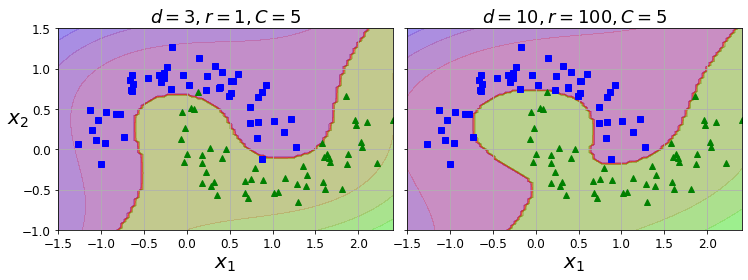

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10.5, 4), sharey=True)

plt.sca(axes[0])        #왼쪽 그래프
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=3, r=1, C=5$", fontsize=18)

plt.sca(axes[1])        #오른쪽 그래프
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=10, r=100, C=5$", fontsize=18)
plt.ylabel("")

save_fig("moons_kernelized_polynomial_svc_plot")
plt.show()

최고차항이 10일때 좀 더 복잡한 결정경계가 그려진다
여기서 r이 위에서 지정한 coef0값

비선형 특성을 다루는 또 다른 기법은 각 샘플이 특정 랜드마크와 얼마나 닮았는지 측정하는 유사도 함수로 계산한 특성을 추가하는 것

유사도 함수로 가우시안 방사 기저 함수(radial basis function) 사용



**식 5-1: 가우시안 RBF**

$
{\displaystyle \phi_{\gamma}(\mathbf{x}, \boldsymbol{\ell})} = {\displaystyle \exp({\displaystyle -\gamma \left\| \mathbf{x} - \boldsymbol{\ell} \right\|^2})}
$




l은 x와 다른 데이터 샘플

x와 l의 L2노름의 제곱

감마가 양수일때 x와 l이 멀리떨어져 있으면 함수값이 0에 가깝게 나오고 x와 l이 가까우면 함수값이 1에 가깝게 나온다 -> 가까이 있는 샘플에 영향을 많이 받고 멀리있는 사이면 영향을 적게 받는다

그림 저장: kernel_method_plot


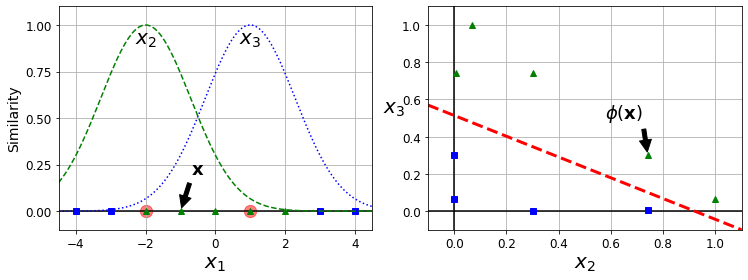

In [ ]:
def gaussian_rbf(x, landmark, gamma):
    return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

gamma = 0.3

x1s = np.linspace(-4.5, 4.5, 200).reshape(-1, 1)        #-4.5~4.5사이에 균등한 200개 숫자배열을 (200,1로)
x2s = gaussian_rbf(x1s, -2, gamma)
x3s = gaussian_rbf(x1s, 1, gamma)


#X1D = np.linspace(-4, 4, 9).reshape(-1, 1) #임의의 데이터 (-4~4사이의 9개의 점이 양성 또는 음성으로 )
XK = np.c_[gaussian_rbf(X1D, -2, gamma), gaussian_rbf(X1D, 1, gamma)]   #X1D에 점들과 -2와 1의 가우시안 RBF 함숫값
yk = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10.5, 4))

plt.subplot(121)    #왼쪽 그래프
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.scatter(x=[-2, 1], y=[0, 0], s=150, alpha=0.5, c="red")     #(-2, 0), (1, 0)에 투명한 붉은 원 표시

plt.plot(X1D[:, 0][yk==0], np.zeros(4), "bs")   #음성 클래스를 파란점
plt.plot(X1D[:, 0][yk==1], np.zeros(5), "g^")   #양성 클래스를 초록점

plt.plot(x1s, x2s, "g--")       #-4.5~4.5사이에 200개의 점과 -2의 관계 / -2에 가까운 점의 함숫값은 1에 가깝게 나온다
plt.plot(x1s, x3s, "b:")        #-4.5~4.5사이에 200개의 점과 1의 관계 / 1에 가까운 점의 함숫값은 1에 가깝게 나온다

plt.gca().get_yaxis().set_ticks([0, 0.25, 0.5, 0.75, 1])        #y축에 눈금 표시
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"Similarity", fontsize=14)
plt.annotate(r'$\mathbf{x}$',
             xy=(X1D[3, 0], 0),
             xytext=(-0.5, 0.20),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.text(-2, 0.9, "$x_2$", ha="center", fontsize=20)
plt.text(1, 0.9, "$x_3$", ha="center", fontsize=20)
plt.axis([-4.5, 4.5, -0.1, 1.1])


plt.subplot(122)        #오른쪽 그래프
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

plt.plot(XK[:, 0][yk==0], XK[:, 1][yk==0], "bs")        #음성클래스인 점의 (-2와의 가우시안 RBF, 1과의 가우시안 RBF)
plt.plot(XK[:, 0][yk==1], XK[:, 1][yk==1], "g^")        #양성클래스인 점의 (-2와의 가우시안 RBF, 1과의 가우시안 RBF)

plt.xlabel(r"$x_2$", fontsize=20)
plt.ylabel(r"$x_3$  ", fontsize=20, rotation=0)
plt.annotate(r'$\phi\left(\mathbf{x}\right)$',
             xy=(XK[3, 0], XK[3, 1]),
             xytext=(0.65, 0.50),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.plot([-0.1, 1.1], [0.57, -0.1], "r--", linewidth=3)
plt.axis([-0.1, 1.1, -0.1, 1.1])
    
plt.subplots_adjust(right=1)

save_fig("kernel_method_plot")
plt.show()

오른쪽 그래프에
-2와 1로 가우시안 RBF를 구해 좌표평면에 점을 찍어보니 선형 방정식으로도 클래스를 나눌수 있다. -> 비선형 데이터 셋으로 만들어서 선형결정경계를 찾아낼 수 있다.

In [ ]:
x1_example = X1D[3, 0]    #4번째 샘플을 뜻함(즉 -1)

for landmark in (-2, 1):    #랜드마크가 -2와 1일때 가우시안 RBF구하기 
    k = gaussian_rbf(np.array([[x1_example]]), np.array([[landmark]]), gamma)
    print("Phi({}, {}) = {}".format(x1_example, landmark, k))

Phi(-1.0, -2) = [0.74081822]
Phi(-1.0, 1) = [0.30119421]


In [ ]:
#SVC클래스에서 kernel="rbf"일때 랜드마크는 나와 다른 모든 데이터가 된다
rbf_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))        #kernel="rbf" -> 가우시안 RBF
    ])                                                          
rbf_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 SVC(C=0.001, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=5,
                     kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

kernel='rbf'일때

지수함수를 테일러급수 전개하면 무한개의 다항식으로 표현되기때문에 굉장히 많은 다항식을 추가하는것과 비슷한 효과가 난다 
(고차원 공간으로 데이터를 전환하는 효과가 난다 -> 실제로는 고차원 공간으로 맵핑하지 않는다)

실제로 PolynomialFeatures처럼 특성의 갯수를 늘리는것은 아니라서 고차원 공간에서 만든 결정경계에 대한 coef값이 없다 -> SVC_coef_값이 없다


그림 저장: moons_rbf_svc_plot


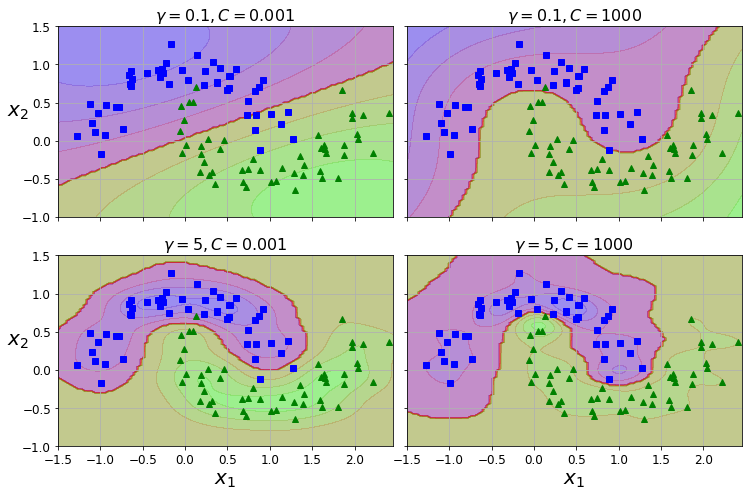

In [ ]:
#감마값과 C값에 따른 결정경계 확인해보기
from sklearn.svm import SVC

gamma1, gamma2 = 0.1, 5     #감마가 커지면 가우시안 RBF값이 줄어든다 -> 샘플간의 영향이 줄어든다(인접한 샘플에만 영향을 미친다) ->복잡한 경계가 만들어 진다
C1, C2 = 0.001, 1000        #C값이 커지면 규제가 감소 -> 모델이 복잡, 경계도 복잡
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []

for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):  #enumerate(svm_clfs) -> svm_clfs 리스트의 (인덱스, 인자)
    plt.sca(axes[i // 2, i % 2])       #(0, 0), (0, 1), (1, 0), (1, 1) 순서대로
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])       #X, y = make_moons(n_samples=100, noise=0.15, random_state=42)
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)
    
    #왼쪽과 밑에만 축표시를 하도록 설정
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")

save_fig("moons_rbf_svc_plot")
plt.show()

# 회귀

분류 : 최대마진을 만드는 결정경계를 찾는거

회귀 : 마진안에 모든 샘플을 포함하는게 목적

In [ ]:
np.random.seed(42)

m = 50      #데이터 갯수

#선형 데이터 생성
X = 2 * np.random.rand(m, 1)        #0~2사이에 균일 분포에서 (m,1)배열
y = (4 + 3 * X + np.random.randn(m, 1)).ravel() #계산한 이차원 배열을 일차원 배열로

LinearSVM, SVR

epsilon은 도로의 폭을 의미

회귀모델 손실함수
max(0, |y - y_hat| - epsilon)

y - y_hat이 입실론보다 작으면 손실이 0이 된다. -> 데이터가 도로안에 들어가면 손실이 0

마진 안에서는 훈련 샘플이 추가되어도 모델의 예측에는 영향이 없다 -> 입실론에 민감하지 않다(epsilon insensitive)

입실론을 크게 하던 작게하던 큰 영향이 없다
도로 밖에 있는 샘플들에 영향을 받아 결정경계가 만들어지기때문에

In [ ]:
from sklearn.svm import LinearSVR

svm_reg = LinearSVR(epsilon=1.5, random_state=42)       #epsilon=0이 기본
svm_reg.fit(X, y)

LinearSVR(C=1.0, dual=True, epsilon=1.5, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=42, tol=0.0001, verbose=0)

In [ ]:
svm_reg1 = LinearSVR(epsilon=1.5, random_state=42)
svm_reg2 = LinearSVR(epsilon=0.5, random_state=42)
svm_reg1.fit(X, y)
svm_reg2.fit(X, y)

def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    off_margin = (np.abs(y - y_pred) >= svm_reg.epsilon)    
    #|y - y_hat|이 입실론 보다 큰 값을 찾는다(만족하면 True) 
    #도로 밖에 있는 있는 데이터(결정경계에 영향을 미치는)를 서포트벡터라고 한다
    
    return np.argwhere(off_margin)      #True인 인덱스 반환

#LinearSVR이 서포트벡터를 안 찾아주기때문에 수동으로 찾아서 대입
#클래스에 없는 속성이라도 객체에 추가가능
svm_reg1.support_ = find_support_vectors(svm_reg1, X, y)
svm_reg2.support_ = find_support_vectors(svm_reg2, X, y)

eps_x1 = 1
eps_y_pred = svm_reg1.predict([[eps_x1]])

그림 저장: svm_regression_plot


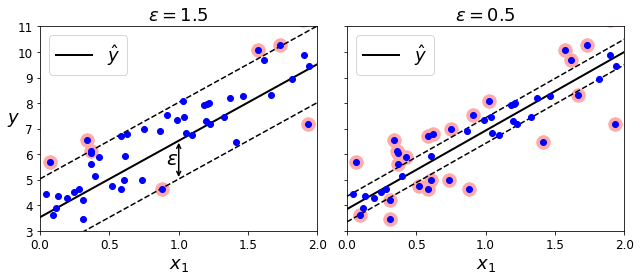

In [ ]:
def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)    #데이터 (100,1)로 만듬
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")    #예측한 값 그리기
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")                  # +입실론만큼 평행이동
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")                  # -입실론만큼 평행이동
    
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA')  #서포트벡터 핑크점표시
    
    plt.plot(X, y, "bo")    #데이터 산점도
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)

plt.sca(axes[0])        #왼쪽 그래프
plot_svm_regression(svm_reg1, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
#plt.plot([eps_x1, eps_x1], [eps_y_pred, eps_y_pred - svm_reg1.epsilon], "k-", linewidth=2)
plt.annotate(
        '', xy=(eps_x1, eps_y_pred), xycoords='data',
        xytext=(eps_x1, eps_y_pred - svm_reg1.epsilon),
        textcoords='data', arrowprops={'arrowstyle': '<->', 'linewidth': 1.5}
    )       # 입실론 표시 y - y_hat이라서 y축에 평행하게
plt.text(0.91, 5.6, r"$\epsilon$", fontsize=20)


plt.sca(axes[1])        #오른쪽 그래프
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg2.epsilon), fontsize=18)
save_fig("svm_regression_plot")
plt.show()

In [ ]:
np.random.seed(42)

m = 100     #데이터 크기

#비선형 데이터 만들기
X = 2 * np.random.rand(m, 1) - 1        #-1~1사이에 (m, 1)배열생성
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()     

**노트**: 향후 버전을 위해 사이킷런 0.22에서 기본값이 될 `gamma="scale"`으로 지정했습니다.

In [ ]:
from sklearn.svm import SVR

svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")  #gamma="scale" -> 1 / (특성개수*데이터분산)
svm_poly_reg.fit(X, y)

SVR(C=100, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
from sklearn.svm import SVR

svm_poly_reg1 = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")     #C값 크게 -> 규제안함 -> 모델 복잡
svm_poly_reg2 = SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1, gamma="scale")    

svm_poly_reg1.fit(X, y)
svm_poly_reg2.fit(X, y)

SVR(C=0.01, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

그림 저장: svm_with_polynomial_kernel_plot


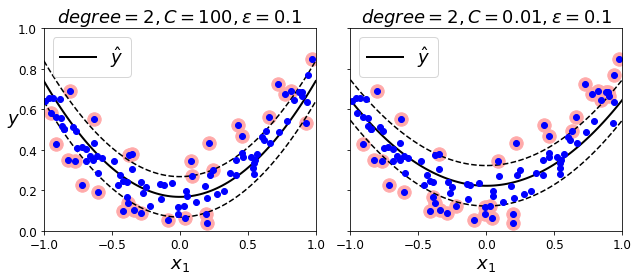

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)

plt.sca(axes[0])        #왼쪽 그래프
plot_svm_regression(svm_poly_reg1, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg1.degree, svm_poly_reg1.C, svm_poly_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)

plt.sca(axes[1])        #오른쪽 그래프
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg2.degree, svm_poly_reg2.C, svm_poly_reg2.epsilon), fontsize=18)

save_fig("svm_with_polynomial_kernel_plot")
plt.show()

왼쪽 그래프의 모델이 더 복잡하므로 기울기가 더 큰것을 볼 수 있다

또 입실론이 y방향과 나란하기때문에 기울기가 큰 부분에서 도로 폭이 작고 기울기가 작은 부분에서 도로 폭이 넓다

# SVM 이론

**식 5-2: 선형 SVM 분류기의 예측**

$
\hat{y} = \begin{cases}
 0 & \mathbf{w}^T \mathbf{x} + b < 0 \text{ 일 때}, \\
 1 & \mathbf{w}^T \mathbf{x} + b \geq 0 \text{ 일 때}
\end{cases}
$

In [ ]:
iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = (iris["target"] == 2).astype(np.float64)  # Iris virginica인게 True 아니면 False를 1과 0으로 바꿈

그림 저장: iris_3D_plot


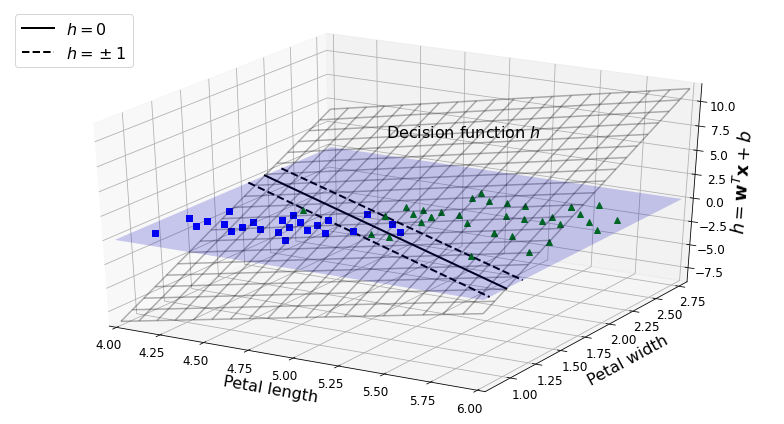

In [ ]:
# 힌지손실 max(0, 1 - t*y)
# 양성 클래스(t==1)일때 y>=1 -> 손실==0
# 음성 클래스(t==-1)일때 y=<-1 -> 손실 ==0
from mpl_toolkits.mplot3d import Axes3D

def plot_3D_decision_function(ax, w, b, x1_lim=[4, 6], x2_lim=[0.8, 2.8]):
    x1_in_bounds = (X[:, 0] > x1_lim[0]) & (X[:, 0] < x1_lim[1])    #꽃잎 길이가 4~6사이인 것만 True
    X_crop = X[x1_in_bounds]    #위 조건을 만족하는 데이터만 
    y_crop = y[x1_in_bounds]    #위 조건을 만족하는 데이터의 레이블만
    
    x1s = np.linspace(x1_lim[0], x1_lim[1], 20)     #x1특성
    x2s = np.linspace(x2_lim[0], x2_lim[1], 20)     #x2특성
    x1, x2 = np.meshgrid(x1s, x2s)                  #x1s와 x2s로 조합할 수 있는 모든 좌표
    xs = np.c_[x1.ravel(), x2.ravel()]
    
    df = (xs.dot(w) + b).reshape(x1.shape)          #결정함수 계산 후 결과 (20,20)으로 재배열 / xs는 2차원 w는 1차원 브로드캐스팅된다
    m = 1 / np.linalg.norm(w)
   
    #y = x1s * w[0] + x2s * w[1] + b ->결정함수 식
    #0 = x1s * w[0] + x2s * w[1] + b -> 결정경계 식
    #1 = x1s * w[0] + x2s * w[1] + b 
    #-1 = x1s * w[0] + x2s * w[1] + b  
    boundary_x2s = -x1s*(w[0]/w[1])-b/w[1]
    margin_x2s_1 = -x1s*(w[0]/w[1])-(b-1)/w[1]
    margin_x2s_2 = -x1s*(w[0]/w[1])-(b+1)/w[1]
    
    ax.plot_surface(x1s, x2, np.zeros_like(x1),
                    color="b", alpha=0.2, cstride=100, rstride=100)     #x, y, z순서이고 파란색 2차 평면을 표시
    ax.plot(x1s, boundary_x2s, 0, "k-", linewidth=2, label=r"$h=0$")        #결정경계
    ax.plot(x1s, margin_x2s_1, 0, "k--", linewidth=2, label=r"$h=\pm 1$")   #결정함수값이 1인 직선 파란색 평면에투영
    ax.plot(x1s, margin_x2s_2, 0, "k--", linewidth=2)                       #결정함수값이 -1인 직선 파란색 평면에 투영
    
    ax.plot(X_crop[:, 0][y_crop==1], X_crop[:, 1][y_crop==1], 0, "g^")      #Iris virginica인 데이터를 초록색으로 표시
    ax.plot_wireframe(x1, x2, df, alpha=0.3, color="k")         
    ax.plot(X_crop[:, 0][y_crop==0], X_crop[:, 1][y_crop==0], 0, "bs")      ##Iris virginica아닌 데이터를 파란색으로 표시
    ax.axis(x1_lim + x2_lim)        #리스트 합치기
    
    ax.text(4.5, 2.5, 3.8, "Decision function $h$", fontsize=16)
    ax.set_xlabel(r"Petal length", fontsize=16, labelpad=10)
    ax.set_ylabel(r"Petal width", fontsize=16, labelpad=10)
    ax.set_zlabel(r"$h = \mathbf{w}^T \mathbf{x} + b$", fontsize=18, labelpad=5)
    ax.legend(loc="upper left", fontsize=16)

fig = plt.figure(figsize=(11, 6))
ax1 = fig.add_subplot(111, projection='3d')

plot_3D_decision_function(ax1, w=svm_clf2.coef_[0], b=svm_clf2.intercept_[0])       #svm_clf2 = LinearSVC(C=100, loss="hinge", random_state=42)
save_fig("iris_3D_plot")
plt.show()

결정함수가 1이 되는 직선을 파란 2차원 평면으로 정사형


결정함수 평면이 누울수록 마진(도로의 폭)이 넓어진다 -> 가중치 w의 노름이 작게(결정함수가 누워지게)하는 것이 목표

# 작은 가중치 벡터가 라지 마진을 만듭니다

그림 저장: small_w_large_margin_plot


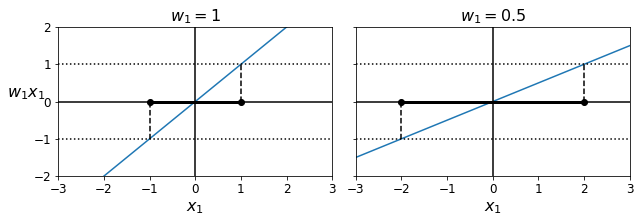

In [ ]:
def plot_2D_decision_function(w, b, ylabel=True, x1_lim=[-3, 3]):
    x1 = np.linspace(x1_lim[0], x1_lim[1], 200)     #x범위에 균일하게 숫자200개 배열
    y = w * x1 + b                                  #결정함수값 계산
    m = 1 / w                                       #마진

    plt.plot(x1, y)
    plt.plot(x1_lim, [1, 1], "k:")      # y=1인 직선
    plt.plot(x1_lim, [-1, -1], "k:")    # y=-1인 직선 
    
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    
    plt.plot([m, m], [0, 1], "k--")     #마진을 투영한다고 그은 x축에 수직인 점선(원점의 오른쪽)
    plt.plot([-m, -m], [0, -1], "k--")  #마진을 투영한다고 그은 x축에 수직인 점선(원점의 왼쪽)
    plt.plot([-m, m], [0, 0], "k-o", linewidth=3)
    
    plt.axis(x1_lim + [-2, 2])
    plt.xlabel(r"$x_1$", fontsize=16)
    
    if ylabel:
        plt.ylabel(r"$w_1 x_1$  ", rotation=0, fontsize=16)
    plt.title(r"$w_1 = {}$".format(w), fontsize=16)

fig, axes = plt.subplots(ncols=2, figsize=(9, 3.2), sharey=True)

plt.sca(axes[0])        #왼쪽 그래프
plot_2D_decision_function(1, 0)     # 

plt.sca(axes[1])        #오른쪽 그래프
plot_2D_decision_function(0.5, 0, ylabel=False)

save_fig("small_w_large_margin_plot")
plt.show()

x축이 특성값, y축이 결정함수값

기울기가 작으면(w1이 작으면) 결정함수가 더 눕는다 -> 결정함수값이 1일때(또는 -1일때) 투영했을 때 특성공간에서 마진이 커진다  

즉, w의 L2노름을 작게하는 것이 특성공간에서 가장 폭이 넓은 도로를 찾을 수 있다.

In [ ]:
#SVC모델 사용
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)] # 꽃잎 길이, 꽃잎 너비
y = (iris["target"] == 2).astype(np.float64) # Iris virginica

svm_clf = SVC(kernel="linear", C=1)
svm_clf.fit(X, y)
svm_clf.predict([[5.3, 1.3]])

array([1.])

**식 5-3: 하드 마진 선형 SVM 분류기 목적 함수**

$
\begin{split}
&\underset{\mathbf{w}, b}{\operatorname{minimize}}\quad{\frac{1}{2}\mathbf{w}^T \mathbf{w}} \\
&\text{subject to} \quad t^{(i)}(\mathbf{w}^T \mathbf{x}^{(i)} + b) \ge 1 \quad \text{for } i = 1, 2, \dots, m
\end{split}
$

1/2을 곱한건 미분했을 때 깔끔하게 하려고

힌지 손실 함수 max(0, 1-t*y)에서 함숫값 0이 돼야해서 1 - t*y < 0 ---> 1 < t*y

(t = 1 or -1, y=손실함숫값)

**식 5-4: 소프트 마진 선형 SVM 분류기 목적 함수**

$
\begin{split}
&\underset{\mathbf{w}, b, \mathbf{\zeta}}{\operatorname{minimize}}\quad{\dfrac{1}{2}\mathbf{w}^T \mathbf{w} + C \sum\limits_{i=1}^m{\zeta^{(i)}}}\\
&\text{subject to} \quad t^{(i)}(\mathbf{w}^T \mathbf{x}^{(i)} + b) \ge 1 - \zeta^{(i)} \quad \text{and} \quad \zeta^{(i)} \ge 0 \quad \text{for } i = 1, 2, \dots, m
\end{split}
$

여기서 제타는 각 샘플에 대한 슬랙 변수이다 i번째 샘플이 얼마나 마진을 위반할지 정한다


$\frac{1}{2}\mathbf{w}^T \mathbf{w}$를 작게 하면 마진이 커진다(도로의 폭이 넓어진다) -> 마진오류가 커진다

마진오류를 작게하려고 제타를 작게한다

두 목표는 상충되므로 하이퍼파라미터 C로 트레이드오프한다.

C가 크면 W값이 커질 수 있다 -> 모델이 복잡, 제타는 작아진다 -> 마진오류는 줄어든다.

C가 작으면 W값이 커지면 안된다(W값이 작아진다) -> 모델이 단순해진다.
제타값이 커질 수 있다 -> 마진 오류가 커진다

LinearSVC 의 dual = True(좌표경사법) 면 쌍대문제를 푼다(쌍대문제를 푸는게 빨라서 기본값은 True)
False(뉴턴 메서드)면 원문제를 푼다

SVC, SVR은 쌍대문제만을 풉니다.(커널 트릭을 사용하기때문에)


**식 5-8: 2차 다항식 매핑**

$
\phi\left(\mathbf{x}\right) = \phi\left( \begin{pmatrix}
  x_1 \\
  x_2
\end{pmatrix} \right) = \begin{pmatrix}
  {x_1}^2 \\
  \sqrt{2} \, x_1 x_2 \\
  {x_2}^2
\end{pmatrix}
$


**식 5-9: 2차 다항식 매핑을 위한 커널 트릭**

$
\begin{split}
\phi(\mathbf{a})^T \phi(\mathbf{b}) & \quad = \begin{pmatrix}
  {a_1}^2 \\
  \sqrt{2} \, a_1 a_2 \\
  {a_2}^2
  \end{pmatrix}^T \begin{pmatrix}
  {b_1}^2 \\
  \sqrt{2} \, b_1 b_2 \\
  {b_2}^2
\end{pmatrix} = {a_1}^2 {b_1}^2 + 2 a_1 b_1 a_2 b_2 + {a_2}^2 {b_2}^2 \\
 & \quad = \left( a_1 b_1 + a_2 b_2 \right)^2 = \left( \begin{pmatrix}
  a_1 \\
  a_2
\end{pmatrix}^T \begin{pmatrix}
    b_1 \\
    b_2
  \end{pmatrix} \right)^2 = (\mathbf{a}^T \mathbf{b})^2
\end{split}
$

a와 b의 내적의 제곱이 특성을 늘려서 곱한것과 같은 효과가 있다 굳이 특성공간을 늘리지 않고도 두 벡터사이의 거리를 마치 고차원특성사이에서의 거리인양 구할 수 있다


**식 5-10: 일반적인 커널**

$
\begin{split}
\text{선형:} & \quad K(\mathbf{a}, \mathbf{b}) = \mathbf{a}^T \mathbf{b} \\
\text{다항식:} & \quad K(\mathbf{a}, \mathbf{b}) = \left(\gamma \mathbf{a}^T \mathbf{b} + r \right)^d \\
\text{가우시안 RBF:} & \quad K(\mathbf{a}, \mathbf{b}) = \exp({\displaystyle -\gamma \left\| \mathbf{a} - \mathbf{b} \right\|^2}) \\
\text{시그모이드:} & \quad K(\mathbf{a}, \mathbf{b}) = \tanh\left(\gamma \mathbf{a}^T \mathbf{b} + r\right)
\end{split}
$

**식 5-13: 선형 SVM 분류기의 비용 함수**

$
J(\mathbf{w}, b) = \dfrac{1}{2} \mathbf{w}^T \mathbf{w} \,+\, C {\displaystyle \sum\limits_{i=1}^{m}max\left(0, t^{(i)} - (\mathbf{w}^T \mathbf{x}^{(i)} + b) \right)}
$

LinearSVC(penalty='l2')일 때 위의 비용함수를 쓰고

LinearSVC(penalty='l1')일때는 $
J(\mathbf{w}, b) = \mathbf{|w|} \,+\, C {\displaystyle \sum\limits_{i=1}^{m}max\left(0, t^{(i)} - (\mathbf{w}^T \mathbf{x}^{(i)} + b) \right)}
$

# 힌지 손실

그림 저장: hinge_plot


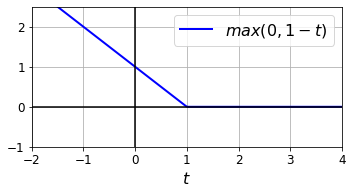

In [ ]:
t = np.linspace(-2, 4, 200)     #t값이 변수
h = np.where(1 - t < 0, 0, 1 - t)  # max(0, 1-t)

plt.figure(figsize=(5,2.8))
plt.plot(t, h, "b-", linewidth=2, label="$max(0, 1 - t)$")
plt.grid(True, which='both')

plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

plt.yticks(np.arange(-1, 2.5, 1))
plt.xlabel("$t$", fontsize=16)
plt.axis([-2, 4, -1, 2.5])
plt.legend(loc="upper right", fontsize=16)

save_fig("hinge_plot")
plt.show()

# 추가 내용

## 훈련 시간

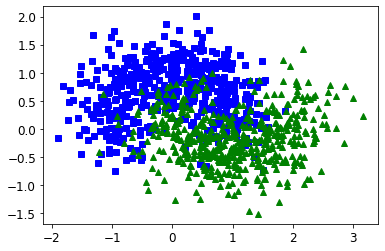

In [ ]:
X, y = make_moons(n_samples=1000, noise=0.4, random_state=42)
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")

[LibSVM]0 0.1 0.40079617500305176
[LibSVM]1 0.01 0.4077270030975342
[LibSVM]2 0.001 0.489579439163208
[LibSVM]3 0.0001 1.1016392707824707
[LibSVM]4 1e-05 2.1797454357147217
[LibSVM]5 1.0000000000000002e-06 1.9688475131988525
[LibSVM]6 1.0000000000000002e-07 14.056094884872437
[LibSVM]7 1.0000000000000002e-08 1.9056017398834229
[LibSVM]8 1.0000000000000003e-09 1.8512012958526611
[LibSVM]9 1.0000000000000003e-10 1.7217018604278564


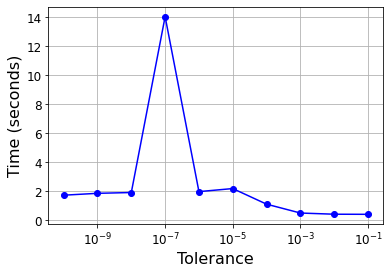

In [ ]:
import time

tol = 0.1
tols = []
times = []

for i in range(10):
    svm_clf = SVC(kernel="poly", gamma=3, C=10, tol=tol, verbose=1)     # 
    t1 = time.time()
    svm_clf.fit(X, y)
    t2 = time.time()
    times.append(t2-t1)
    tols.append(tol)
    print(i, tol, t2-t1)
    tol /= 10       #tol값을 0.1배 줄여가며 시간을 잰다

plt.semilogx(tols, times, "bo-")
plt.xlabel("Tolerance", fontsize=16)
plt.ylabel("Time (seconds)", fontsize=16)
plt.grid(True)
plt.show()

tol 값을 낮추면 훈련 시간이 오래 걸린다

## 배치 경사 하강법을 사용한 선형 SVM 분류기 구현

In [ ]:
# 훈련 세트
X = iris["data"][:, (2, 3)] # # 꽃잎 길이, 꽃잎 너비
y = (iris["target"] == 2).astype(np.float64).reshape(-1, 1) # Iris virginica종이면 1 아니면 0

In [ ]:
from sklearn.base import BaseEstimator

class MyLinearSVC(BaseEstimator):   #BaseEstimator를 상속받아야 그리드서치나 크로스 벨리데이션 사용가능
    def __init__(self, C=1, eta0=1, eta_d=10000, n_epochs=1000, random_state=None):
        self.C = C
        self.eta0 = eta0
        self.n_epochs = n_epochs
        self.random_state = random_state
        self.eta_d = eta_d

    def eta(self, epoch):
        return self.eta0 / (epoch + self.eta_d)     #에폭이 늘어남에 따라 학습률이 감소
        
    def fit(self, X, y):
        #가중치 w 랜덤 초기화
        if self.random_state:
            np.random.seed(self.random_state)
        w = np.random.randn(X.shape[1], 1) # n feature weights
        b = 0

        m = len(X)      #데이터 갯수
        t = y * 2 - 1  # y==1 -> t==1 , y==0 -> t==-1 (150, 1)
        # 1 - t*(w*x + b)
        # 1 - tx * w - t*b
        X_t = X * t     #손실함수(힌지손실)의 오른쪽 항을 계산하기 편하게 미리 일부를 계산함
        self.Js=[]

        # Training
        for epoch in range(self.n_epochs):
            support_vectors_idx = (X_t.dot(w) + t * b < 1).ravel()      #마진 안에 들어있는 서포트벡터 찾기
            X_t_sv = X_t[support_vectors_idx]
            t_sv = t[support_vectors_idx]

            J = 1/2 * np.sum(w * w) + self.C * (np.sum(1 - X_t_sv.dot(w)) - b * np.sum(t_sv))   #선형 SVM 분류기의 비용함수
            self.Js.append(J)

            w_gradient_vector = w - self.C * np.sum(X_t_sv, axis=0).reshape(-1, 1)      
            #J를 w에 대해 미분하면 앞항에서는 w만 남고 1 - tx * w - t*b 에서는 -tx(-xt)만 남음
            b_derivative = -C * np.sum(t_sv)
            #1 - tx * w - t*b에서 b에 대해 미분하면 -t만 남아서
                
            w = w - self.eta(epoch) * w_gradient_vector     #파라미터 갱신
            b = b - self.eta(epoch) * b_derivative          #파라미터 갱신
            

        self.intercept_ = np.array([b])     #갱신한 최종 b(편향또는 절편)을 인스턴스변수??속성값에 저장 
        self.coef_ = np.array([w])          #갱신한 최종 w(가중치)를 속성값에 저장 
        
        support_vectors_idx = (X_t.dot(w) + t * b < 1).ravel()  #갱신된 w와 b에 대해 다시 마진안에 들어있는 서포트벡터를 구한다 
        self.support_vectors_ = X[support_vectors_idx]
        return self

    def decision_function(self, X):
        return X.dot(self.coef_[0]) + self.intercept_[0]        #결정함수값

    def predict(self, X):
        return (self.decision_function(X) >= 0).astype(np.float64)  #결정함수값이 0보다 크면 1 -> 양성 클래스로 예측
                                                                    #0보다 작으면 0 -> 음성클래스로 예측

C=2
svm_clf = MyLinearSVC(C=C, eta0 = 10, eta_d = 1000, n_epochs=60000, random_state=2)
svm_clf.fit(X, y)
svm_clf.predict(np.array([[5, 2], [4, 1]]))

array([[1.],
       [0.]])

(0.0, 60000.0, 0.0, 100.0)

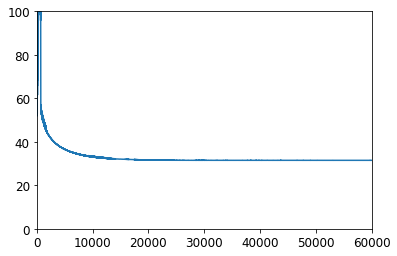

In [ ]:
plt.plot(range(svm_clf.n_epochs), svm_clf.Js)       #svm_clf.Js는 손실함수 값이 들어간 리스트
plt.axis([0, svm_clf.n_epochs, 0, 100])

In [ ]:
print(svm_clf.intercept_, svm_clf.coef_)

[-15.56761653] [[[2.28120287]
  [2.71621742]]]


In [ ]:
svm_clf2 = SVC(kernel="linear", C=C)
svm_clf2.fit(X, y.ravel())
print(svm_clf2.intercept_, svm_clf2.coef_)

[-15.51721253] [[2.27128546 2.71287145]]


(4.0, 6.0, 0.8, 2.8)

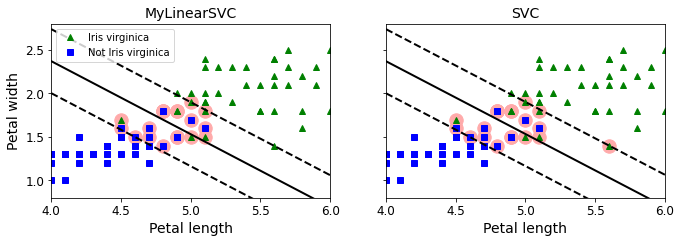

In [ ]:
#위에서 만든 모델과 사이킷런에 있는 모델 비교

yr = y.ravel()      #이차원 배열을 일차원 배열로
fig, axes = plt.subplots(ncols=2, figsize=(11, 3.2), sharey=True)

plt.sca(axes[0])        #왼쪽 그래프
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^", label="Iris virginica")      #아이리스종을 초록색
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs", label="Not Iris virginica")  #아이리스종이 아닌것을 파란색으로

plot_svc_decision_boundary(svm_clf, 4, 6)       #결정경계 그리는 함수

plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.title("MyLinearSVC", fontsize=14)
plt.axis([4, 6, 0.8, 2.8])
plt.legend(loc="upper left")

plt.sca(axes[1])        #오른쪽 그래프
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs")

plot_svc_decision_boundary(svm_clf2, 4, 6)

plt.xlabel("Petal length", fontsize=14)
plt.title("SVC", fontsize=14)
plt.axis([4, 6, 0.8, 2.8])


둘의 결과가 비슷하다

[-12.52988101   1.94162342   1.84544824]


(4.0, 6.0, 0.8, 2.8)

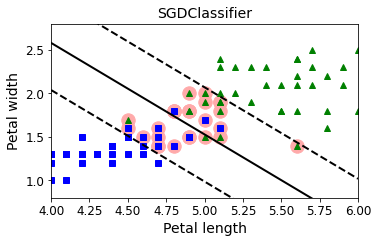

In [ ]:
from sklearn.linear_model import SGDClassifier      #확률적 경사하강법

sgd_clf = SGDClassifier(loss="hinge", alpha=0.017, max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X, y.ravel())

m = len(X)
t = y * 2 - 1  # t==0이면 -1, t==1이면 +1
X_b = np.c_[np.ones((m, 1)), X]  # 편향 x0=1을 추가합니다
X_b_t = X_b * t

sgd_theta = np.r_[sgd_clf.intercept_[0], sgd_clf.coef_[0]]
print(sgd_theta)

support_vectors_idx = (X_b_t.dot(sgd_theta) < 1).ravel()
sgd_clf.support_vectors_ = X[support_vectors_idx]
sgd_clf.C = C

plt.figure(figsize=(5.5,3.2))
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs")

plot_svc_decision_boundary(sgd_clf, 4, 6)

plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.title("SGDClassifier", fontsize=14)
plt.axis([4, 6, 0.8, 2.8])


# 연습문제 해답

## 1. to 7.

부록 A 참조.

# 8.

_문제: 선형적으로 분리되는 데이터셋에 `LinearSVC`를 훈련시켜보세요. 그런 다음 같은 데이터셋에 `SVC`와`SGDClassifier`를 적용해보세요. 거의 비슷한 모델이 만들어지는지 확인해보세요._

Iris 데이터셋을 사용하겠습니다. Iris Setosa와 Iris Versicolor 클래스는 선형적으로 구분이 가능합니다.

In [ ]:
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

In [ ]:
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

C = 5
alpha = 1 / (C * len(X))

lin_clf = LinearSVC(loss="hinge", C=C, random_state=42)
svm_clf = SVC(kernel="linear", C=C)
sgd_clf = SGDClassifier(loss="hinge", learning_rate="constant", eta0=0.001, alpha=alpha,
                        max_iter=1000, tol=1e-3, random_state=42)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lin_clf.fit(X_scaled, y)
svm_clf.fit(X_scaled, y)
sgd_clf.fit(X_scaled, y)

print("LinearSVC:                   ", lin_clf.intercept_, lin_clf.coef_)
print("SVC:                         ", svm_clf.intercept_, svm_clf.coef_)
print("SGDClassifier(alpha={:.5f}):".format(sgd_clf.alpha), sgd_clf.intercept_, sgd_clf.coef_)

LinearSVC:                    [0.28474272] [[1.05364736 1.09903308]]
SVC:                          [0.31896852] [[1.1203284  1.02625193]]
SGDClassifier(alpha=0.00200): [0.117] [[0.77714169 0.72981762]]


이 3개 모델의 결정 경계를 그려 보겠습니다:

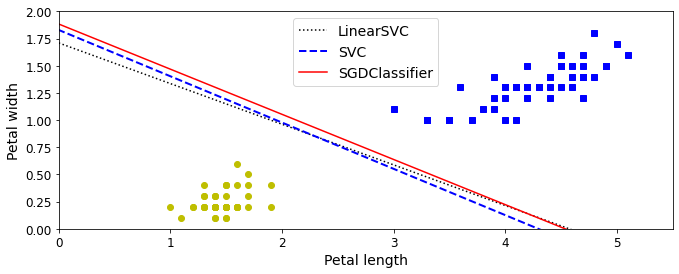

In [ ]:
# 각 결정 경계의 기울기와 편향을 계산합니다
w1 = -lin_clf.coef_[0, 0]/lin_clf.coef_[0, 1]
b1 = -lin_clf.intercept_[0]/lin_clf.coef_[0, 1]
w2 = -svm_clf.coef_[0, 0]/svm_clf.coef_[0, 1]
b2 = -svm_clf.intercept_[0]/svm_clf.coef_[0, 1]
w3 = -sgd_clf.coef_[0, 0]/sgd_clf.coef_[0, 1]
b3 = -sgd_clf.intercept_[0]/sgd_clf.coef_[0, 1]

# 결정 경계를 원본 스케일로 변환합니다
line1 = scaler.inverse_transform([[-10, -10 * w1 + b1], [10, 10 * w1 + b1]])
line2 = scaler.inverse_transform([[-10, -10 * w2 + b2], [10, 10 * w2 + b2]])
line3 = scaler.inverse_transform([[-10, -10 * w3 + b3], [10, 10 * w3 + b3]])

# 세 개의 결정 경계를 모두 그립니다
plt.figure(figsize=(11, 4))
plt.plot(line1[:, 0], line1[:, 1], "k:", label="LinearSVC")
plt.plot(line2[:, 0], line2[:, 1], "b--", linewidth=2, label="SVC")
plt.plot(line3[:, 0], line3[:, 1], "r-", label="SGDClassifier")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs") # label="Iris versicolor"
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo") # label="Iris setosa"
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper center", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.show()

아주 비슷하네요!

# 9.

_문제: MNIST 데이터셋에 SVM 분류기를 훈련시켜보세요. SVM 분류기는 이진 분류기라서 OvA 전략을 사용해 10개의 숫자를 분류해야 합니다. 처리 속도를 높이기 위해 작은 검증 세트로 하이퍼파라미터를 조정하는 것이 좋습니다. 어느 정도까지 정확도를 높일 수 있나요?_

먼저 데이터셋을 로드하고 훈련 세트와 테스트 세트로 나눕니다. `train_test_split()` 함수를 사용할 수 있지만 보통 처음 60,000개의 샘플을 훈련 세트로 사용하고 나머지는 10,000개를 테스트 세트로 사용합니다(이렇게 하면 다른 사람들의 모델과 성능을 비교하기 좋습니다):

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)

X = mnist["data"]
y = mnist["target"].astype(np.uint8)

X_train = X[:60000]
y_train = y[:60000]
X_test = X[60000:]
y_test = y[60000:]

많은 훈련 알고리즘은 훈련 샘플의 순서에 민감하므로 먼저 이를 섞는 것이 좋은 습관입니다. 하지만 이 데이터셋은 이미 섞여있으므로 이렇게 할 필요가 없습니다.

선형 SVM 분류기부터 시작해보죠. 이 모델은 자동으로 OvA(또는 OvR) 전략을 사용하므로 특별히 처리해 줄 것이 없습니다. 간단하네요!

**경고**: 이 작업은 하드웨어에 따라 몇 분이 걸릴 수 있습니다.

In [ ]:
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)

훈련 세트에 대한 예측을 만들어 정확도를 측정해 보겠습니다(최종 모델을 선택해 훈련시킨 것이 아니기 때문에 아직 테스트 세트를 사용해서는 안됩니다):

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = lin_clf.predict(X_train)
accuracy_score(y_train, y_pred)

0.8733

MNIST에서 89.5% 정확도면 나쁜 성능입니다. 선형 모델이 MNIST 문제에 너무 단순하기 때문이지만 먼저 데이터의 스케일을 조정할 필요가 있습니다:

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32))
X_test_scaled = scaler.transform(X_test.astype(np.float32))

**경고**: 이 작업은 하드웨어에 따라 몇 분이 걸릴 수 있습니다.

In [ ]:
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_train_scaled, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)

In [ ]:
y_pred = lin_clf.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.9226833333333333

훨씬 나아졌지만(에러율을 절반으로 줄였습니다) 여전히 MNIST에서 좋은 성능은 아닙니다. SVM을 사용한다면 커널 함수를 사용해야 합니다. RBF 커널(기본값)로 `SVC`를 적용해 보겠습니다.

**노트**: 향후 버전을 위해 사이킷런 0.22에서 기본값인 `gamma="scale"`을 지정합니다.

In [ ]:
svm_clf = SVC(gamma="scale")
svm_clf.fit(X_train_scaled[:10000], y_train[:10000])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
y_pred = svm_clf.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.9455333333333333

아주 좋네요 6배나 적은 데이터에서 모델을 훈련시켰지만 더 좋은 성능을 얻었습니다. 교차 검증을 사용한 랜덤 서치로 하이퍼파라미터 튜닝을 해보겠습니다. 진행을 빠르게 하기 위해 작은 데이터셋으로 작업하겠습니다:

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(svm_clf, param_distributions, n_iter=10, verbose=2, cv=3)
rnd_search_cv.fit(X_train_scaled[:1000], y_train[:1000])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=5.847490967837556, gamma=0.004375955271336425 .................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .. C=5.847490967837556, gamma=0.004375955271336425, total=   1.2s
[CV] C=5.847490967837556, gamma=0.004375955271336425 .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] .. C=5.847490967837556, gamma=0.004375955271336425, total=   1.2s
[CV] C=5.847490967837556, gamma=0.004375955271336425 .................
[CV] .. C=5.847490967837556, gamma=0.004375955271336425, total=   1.2s
[CV] C=2.544266730893301, gamma=0.024987648190235304 .................
[CV] .. C=2.544266730893301, gamma=0.024987648190235304, total=   1.3s
[CV] C=2.544266730893301, gamma=0.024987648190235304 .................
[CV] .. C=2.544266730893301, gamma=0.024987648190235304, total=   1.3s
[CV] C=2.544266730893301, gamma=0.024987648190235304 .................
[CV] .. C=2.544266730893301, gamma=0.024987648190235304, total=   1.3s
[CV] C=2.199505425963898, gamma=0.009340106304825553 .................
[CV] .. C=2.199505425963898, gamma=0.009340106304825553, total=   1.3s
[CV] C=2.199505425963898, gamma=0.009340106304825553 .................
[CV] .. C=2.199505425963898, gamma=0.009340106304825553, total=   1.3s
[CV] C=2.199505425963898, gamma=0.009340106304825553 .................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   38.7s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                 class_weight=None, coef0=0.0,
                                 decision_function_shape='ovr', degree=3,
                                 gamma='scale', kernel='rbf', max_iter=-1,
                                 probability=False, random_state=None,
                                 shrinking=True, tol=0.001, verbose=False),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f38a0955dd0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f38a0955310>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=2)

In [ ]:
rnd_search_cv.best_estimator_

SVC(C=3.8786881587000437, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma=0.0017076019229344522, kernel='rbf', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)

In [ ]:
rnd_search_cv.best_score_

0.8599947252641863

이 점수는 낮지만 1,000개의 샘플만 사용한 것을 기억해야 합니다. 전체 데이터셋으로 최선의 모델을 재훈련시켜 보겠습니다(몇 시간이 걸릴지 모르니 잠들기 전에 돌려 보세요):

In [ ]:
rnd_search_cv.best_estimator_.fit(X_train_scaled, y_train)

SVC(C=3.8786881587000437, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma=0.0017076019229344522, kernel='rbf', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)

In [ ]:
y_pred = rnd_search_cv.best_estimator_.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

아주 훌륭하네요! 이 모델을 선택하겠습니다. 이제 테스트 세트로 모델을 테스트합니다:

In [ ]:
y_pred = rnd_search_cv.best_estimator_.predict(X_test_scaled)
accuracy_score(y_test, y_pred)

아주 나쁘지 않지만 확실히 모델이 다소 과대적합되었습니다. 하이퍼파라미터를 조금 더 수정할 수 있지만(가령, `C`와/나 `gamma`를 감소시킵니다) 그렇게 하면 테스트 세트에 과대적합될 위험이 있습니다. 다른 사람들은 하이퍼파라미터 `C=5`와 `gamma=0.005`에서 더 나은 성능(98% 이상의 정확도)을 얻었습니다. 훈련 세트를 더 많이 사용해서 더 오래 랜덤 서치를 수행하면 이런 값을 얻을 수 있을지 모릅니다.

## 10.

_문제: 캘리포니아 주택 가격 데이터셋에 SVM 회귀를 훈련시켜보세요._

사이킷런의 `fetch_california_housing()` 함수를 사용해 데이터셋을 로드합니다:

In [ ]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
X = housing["data"]
y = housing["target"]

훈련 세트와 테스트 세트로 나눕니다:

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

데이터의 스케일을 조정하는 것을 잊지 마세요:

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

먼저 간단한 `LinearSVR`을 훈련시켜 보죠:

In [ ]:
from sklearn.svm import LinearSVR

lin_svr = LinearSVR(random_state=42)
lin_svr.fit(X_train_scaled, y_train)

훈련 세트에 대한 성능을 확인해 보겠습니다:

In [ ]:
from sklearn.metrics import mean_squared_error

y_pred = lin_svr.predict(X_train_scaled)
mse = mean_squared_error(y_train, y_pred)
mse

RMSE를 확인해 보겠습니다:

In [ ]:
np.sqrt(mse)

훈련 세트에서 타깃은 만달러 단위입니다. RMSE는 기대할 수 있는 에러의 정도를 대략 가늠하게 도와줍니다(에러가 클수록 큰 폭으로 증가합니다). 이 모델의 에러가 대략 $10,000 정도로 예상할 수 있습니다. 썩 훌륭하지 않네요. RBF 커널이 더 나을지 확인해 보겠습니다. 하이퍼파라미터 `C`와 `gamma`의 적절한 값을 찾기 위해 교차 검증을 사용한 랜덤 서치를 적용하겠습니다:

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(SVR(), param_distributions, n_iter=10, verbose=2, cv=3, random_state=42)
rnd_search_cv.fit(X_train_scaled, y_train)

In [ ]:
rnd_search_cv.best_estimator_

이제 훈련 세트에서 RMSE를 측정해 보겠습니다:

In [ ]:
y_pred = rnd_search_cv.best_estimator_.predict(X_train_scaled)
mse = mean_squared_error(y_train, y_pred)
np.sqrt(mse)

선형 모델보다 훨씬 나아졌네요. 이 모델을 선택하고 테스트 세트에서 평가해 보겠습니다:

In [ ]:
y_pred = rnd_search_cv.best_estimator_.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
np.sqrt(mse)